# Unsupervised Machine Learning Quantitative Trading Strategy

# Packages

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing the data and some cleaning 

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-05-15'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)
df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df


[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-05-17 A        41.673550   44.410000   45.340000   43.630001   44.959999   
           AAL      31.367802   32.639999   33.290001   32.020000   32.250000   
           AAPL     21.467327   23.372499   23.674999   23.252501   23.637501   
           ABBV     42.698223   60.250000   62.790001   58.500000   62.439999   
           ABT      32.547661   37.709999   38.299999   37.549999   38.220001   
...                       ...         ...         ...         ...         ...   
2024-05-14 XYL     142.070007  142.070007  142.720001  140.929993  141.259995   
           YUM     136.817657  137.490005  138.449997  136.190002  136.520004   
           ZBH     119.970001  119.970001  120.510002  118.330002  119.949997   
           ZBRA    320.980011  320.980011  322.779999  317.850006  318.390015   
           ZTS     168.869995  168.869995  170.199997  168.630005  169.809998   

Price                   volume  
date       ticker               
2016-05-17 A         7130400.0  
           AAL      13303400.0  
           AAPL    187667600.0  
           ABBV     31528900.0  
           ABT       8357100.0  
...                        ...  
2024-05-14 XYL        949800.0  
           YUM       2180300.0  
           ZBH       1348700.0  
           ZBRA       216300.0  
           ZTS       2050100.0  

[992310 rows x 6 columns]

# Using Technical Indicators for the stock
* Garman-Klass Volatility
* Bollinger Bands
* Dollar Volume
* ATR
* RSI

In [3]:
# Adding the technical indicators

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])



In [4]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)



In [5]:

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-05-17 A        41.673550   44.410000   45.340000   43.630001   44.959999   
           AAL      31.367802   32.639999   33.290001   32.020000   32.250000   
           AAPL     21.467327   23.372499   23.674999   23.252501   23.637501   
           ABBV     42.698223   60.250000   62.790001   58.500000   62.439999   
           ABT      32.547661   37.709999   38.299999   37.549999   38.220001   
...                       ...         ...         ...         ...         ...   
2024-05-14 XYL     142.070007  142.070007  142.720001  140.929993  141.259995   
           YUM     136.817657  137.490005  138.449997  136.190002  136.520004   
           ZBH     119.970001  119.970001  120.510002  118.330002  119.949997   
           ZBRA    320.980011  320.980011  322.779999  317.850006  318.390015   
           ZTS     168.869995  168.869995  170.199997  168.630005  169.809998   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-05-17 A         7130400.0         -0.001487        NaN       NaN   
           AAL      13303400.0          0.000459        NaN       NaN   
           AAPL    187667600.0         -0.003420        NaN       NaN   
           ABBV     31528900.0         -0.053291        NaN       NaN   
           ABT       8357100.0         -0.009775        NaN       NaN   
...                        ...               ...        ...       ...   
2024-05-14 XYL        949800.0          0.000067  72.345766  4.826447   
           YUM       2180300.0          0.000134  50.038958  4.896062   
           ZBH       1348700.0          0.000167  43.928989  4.783957   
           ZBRA       216300.0          0.000093  63.795659  5.579050   
           ZTS       2050100.0          0.000031  54.271356  4.977996   

Price                bb_mid   bb_high       atr  dollar_volume  
date       ticker                                               
2016-05-17 A            NaN       NaN       NaN     297.149078  
           AAL          NaN       NaN       NaN     417.298413  
           AAPL         NaN       NaN       NaN    4028.721759  
           ABBV         NaN       NaN       NaN    1346.228007  
           ABT          NaN       NaN       NaN     272.004056  
...                     ...       ...       ...            ...  
2024-05-14 XYL     4.908653  4.990858  0.599989     134.938093  
           YUM     4.931665  4.967268  0.565743     298.303539  
           ZBH     4.799657  4.815357 -0.411252     161.803541  
           ZBRA    5.705390  5.831730  0.163665      69.427976  
           ZTS     5.078256  5.178516  1.126608     346.200377  

[992310 rows x 13 columns]

# Aggregating at month level and filtering most liquid stocks

In [6]:
# Month level to assist in training time

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()



In [7]:
# Adding a 5 year rolling average of dollar volume for each stocks

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-05-31 AAL      46.985199  0.552626  3.886832  3.763659  3.825246   
           AAPL     35.748734 -1.187388  3.637560  3.567802  3.602681   
           ABBV     48.592529 -1.603542  3.921028  3.889571  3.905300   
           ABT      40.407566 -1.347422  3.719186  3.659323  3.689255   
           ACN     112.053116 -1.225955  4.725428  4.687239  4.706334   
...                       ...       ...       ...       ...       ...   
2024-05-31 VZ       40.490002 -0.575182  3.732135  3.677752  3.704943   
           WFC      61.889999 -0.227148  4.149019  4.071832  4.110425   
           WMT      59.860001  0.565754  4.123502  4.089234  4.106368   
           XOM     117.669998  0.451999  4.803086  4.744902  4.773994   
           ZTS     168.869995  1.126608  5.178516  4.977996  5.078256   

                   garman_klass_vol        rsi  
date       ticker                               
2017-05-31 AAL            -0.000056  60.617018  
           AAPL           -0.002044  61.065232  
           ABBV           -0.037005  54.399774  
           ABT            -0.004774  64.674775  
           ACN            -0.003928  62.532056  
...                             ...        ...  
2024-05-31 VZ              0.000020  54.810677  
           WFC             0.000113  68.511672  
           WMT             0.000125  51.977150  
           XOM             0.000036  56.409657  
           ZTS             0.000031  54.271356  

[12665 rows x 7 columns]

# Using different time horizons as features & calculate monthly returns

In [8]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-05-31 AAL      42.618011  1.371281  3.801628  3.728982  3.765305   
           AAPL     44.410900 -1.026026  3.844051  3.784342  3.814196   
           ABBV     75.292397  0.483896  4.422443  4.323378  4.372910   
           ABT      55.550385 -0.773944  4.066918  3.981285  4.024102   
           ACN     142.810806 -0.853128  4.982193  4.942734  4.962464   
...                       ...       ...       ...       ...       ...   
2024-05-31 VRTX    428.589996  1.152809  6.063452  5.949887  6.006669   
           VZ       40.490002 -0.575182  3.732135  3.677752  3.704943   
           WFC      61.889999 -0.227148  4.149019  4.071832  4.110425   
           WMT      59.860001  0.565754  4.123502  4.089234  4.106368   
           XOM     117.669998  0.451999  4.803086  4.744902  4.773994   

                   garman_klass_vol        rsi  return_1m  return_2m  \
date       ticker                                                      
2018-05-31 AAL             0.000660  45.114574   0.016581  -0.083533   
           AAPL           -0.001003  59.945424   0.135124   0.057390   
           ABBV           -0.032834  46.193266   0.024754   0.027693   
           ABT            -0.004457  54.184883   0.058489   0.015781   
           ACN            -0.002942  53.108585   0.030026   0.011704   
...                             ...        ...        ...        ...   
2024-05-31 VRTX            0.000154  64.790517   0.091087   0.012576   
           VZ              0.000020  54.810677   0.025323  -0.009751   
           WFC             0.000113  68.511672   0.049322   0.036313   
           WMT             0.000125  51.977150   0.012084  -0.000855   
           XOM             0.000036  56.409657   0.003008   0.010210   

                   return_3m  return_6m  return_9m  return_12m  
date       ticker                                               
2018-05-31 AAL     -0.069961  -0.023688  -0.002302   -0.008097  
           AAPL     0.017418   0.015402   0.015909    0.018245  
           ABBV    -0.047916   0.006367   0.033601    0.037166  
           ABT      0.008199   0.016325   0.022849    0.026878  
           ACN     -0.008131   0.009999   0.021704    0.020418  
...                      ...        ...        ...         ...  
2024-05-31 VRTX     0.006181   0.031987   0.023303    0.023700  
           VZ       0.009289   0.014709   0.022492    0.016765  
           WFC      0.038415   0.058405   0.048512    0.039999  
           WMT      0.009363   0.025882   0.012278    0.018094  
           XOM      0.043101   0.025832   0.009275    0.014754  

[10504 rows x 13 columns]

# Calculate rolling Factor Betas using fama-french factors
* Internalizing Market risk, size, value, operating profitability & investments

In [9]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-05-31 AAL     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.016581
           AAPL    0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.135124
           ABBV    0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.024754
           ABT     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.058489
           ACN     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.030026
...                   ...     ...     ...     ...     ...        ...
2024-03-31 VRTX    0.0283 -0.0116  0.0419  0.0148  0.0118  -0.006489
           VZ      0.0283 -0.0116  0.0419  0.0148  0.0118   0.048476
           WFC     0.0283 -0.0116  0.0419  0.0148  0.0118   0.042634
           WMT     0.0283 -0.0116  0.0419  0.0148  0.0118   0.030113
           XOM     0.0283 -0.0116  0.0419  0.0148  0.0118   0.112132

[10218 rows x 6 columns]

In [10]:
#Filter out stocks with less than 10 months of data.
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-05-31 AAL     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.016581
           AAPL    0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.135124
           ABBV    0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.024754
           ABT     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.058489
           ACN     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.030026
...                   ...     ...     ...     ...     ...        ...
2024-03-31 VRTX    0.0283 -0.0116  0.0419  0.0148  0.0118  -0.006489
           VZ      0.0283 -0.0116  0.0419  0.0148  0.0118   0.048476
           WFC     0.0283 -0.0116  0.0419  0.0148  0.0118   0.042634
           WMT     0.0283 -0.0116  0.0419  0.0148  0.0118   0.030113
           XOM     0.0283 -0.0116  0.0419  0.0148  0.0118   0.112132

[10186 rows x 6 columns]

In [11]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(12, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-05-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-03-31 VRTX    0.002419  1.191426 -1.125173  0.812419  2.229872
           VZ      1.094040 -2.109915  1.116061  0.239988 -0.275356
           WFC     0.792886  0.333646 -0.757861 -1.129131  1.659266
           WMT     0.461417  0.369983 -0.726484  1.220368  0.749982
           XOM     0.751695 -0.334809  0.171555  1.584378  1.073788

[10186 rows x 5 columns]

In [12]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10456 entries, (Timestamp('2018-05-31 00:00:00', freq='M'), 'AAL') to (Timestamp('2024-05-31 00:00:00', freq='M'), 'XOM')
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10456 non-null  float64
 1   bb_high           10456 non-null  float64
 2   bb_low            10456 non-null  float64
 3   bb_mid            10456 non-null  float64
 4   garman_klass_vol  10456 non-null  float64
 5   rsi               10456 non-null  float64
 6   return_1m         10456 non-null  float64
 7   return_2m         10456 non-null  float64
 8   return_3m         10456 non-null  float64
 9   return_6m         10456 non-null  float64
 10  return_9m         10456 non-null  float64
 11  return_12m        10456 non-null  float64
 12  Mkt-RF            10456 non-null  float64
 13  SMB               10456 non-null  float64
 14  HML               10456 non-null  floa

In [13]:
data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-05-31 AAL     1.371281  3.801628  3.728982  3.765305          0.000660   
           AAPL   -1.026026  3.844051  3.784342  3.814196         -0.001003   
           ABBV    0.483896  4.422443  4.323378  4.372910         -0.032834   
           ABT    -0.773944  4.066918  3.981285  4.024102         -0.004457   
           ACN    -0.853128  4.982193  4.942734  4.962464         -0.002942   
...                     ...       ...       ...       ...               ...   
2024-05-31 VRTX    1.152809  6.063452  5.949887  6.006669          0.000154   
           VZ     -0.575182  3.732135  3.677752  3.704943          0.000020   
           WFC    -0.227148  4.149019  4.071832  4.110425          0.000113   
           WMT     0.565754  4.123502  4.089234  4.106368          0.000125   
           XOM     0.451999  4.803086  4.744902  4.773994          0.000036   

                         rsi  return_1m  return_2m  return_3m  return_6m  \
date       ticker                                                          
2018-05-31 AAL     45.114574   0.016581  -0.083533  -0.069961  -0.023688   
           AAPL    59.945424   0.135124   0.057390   0.017418   0.015402   
           ABBV    46.193266   0.024754   0.027693  -0.047916   0.006367   
           ABT     54.184883   0.058489   0.015781   0.008199   0.016325   
           ACN     53.108585   0.030026   0.011704  -0.008131   0.009999   
...                      ...        ...        ...        ...        ...   
2024-05-31 VRTX    64.790517   0.091087   0.012576   0.006181   0.031987   
           VZ      54.810677   0.025323  -0.009751   0.009289   0.014709   
           WFC     68.511672   0.049322   0.036313   0.038415   0.058405   
           WMT     51.977150   0.012084  -0.000855   0.009363   0.025882   
           XOM     56.409657   0.003008   0.010210   0.043101   0.025832   

                   return_9m  return_12m    Mkt-RF       SMB       HML  \
date       ticker                                                        
2018-05-31 AAL     -0.002302   -0.008097  1.294504  1.810254  0.120079   
           AAPL     0.015909    0.018245  1.241497 -0.307947 -0.653795   
           ABBV     0.033601    0.037166  0.602155  0.086033 -0.045139   
           ABT      0.022849    0.026878  0.869802 -0.183765 -0.434174   
           ACN      0.021704    0.020418  1.328230 -0.414686 -0.274656   
...                      ...         ...       ...       ...       ...   
2024-05-31 VRTX     0.023303    0.023700  0.856440  0.152323 -1.114997   
           VZ       0.022492    0.016765  0.542184 -0.132882 -0.089848   
           WFC      0.048512    0.039999  1.064106  0.216862  1.233885   
           WMT      0.012278    0.018094  0.618270 -0.359420 -0.213789   
           XOM      0.009275    0.014754  1.127936  0.374182  0.394283   

                        RMW       CMA  
date       ticker                      
2018-05-31 AAL     0.695025  0.702824  
           AAPL    0.875492  0.542572  
           ABBV   -0.378999  0.210806  
           ABT     0.274010  1.110124  
           ACN    -0.329218  0.185110  
...                     ...       ...  
2024-05-31 VRTX   -0.213695  1.044357  
           VZ      0.680381  0.583334  
           WFC    -0.549230 -0.576795  
           WMT     0.691141  0.662598  
           XOM    -0.044434  0.674810  

[10456 rows x 17 columns]

In [14]:
from sklearn.cluster import KMeans


def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

  File "C:\Users\NoSoupForU\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-05-31 AAL     1.371281  3.801628  3.728982  3.765305          0.000660   
           AAPL   -1.026026  3.844051  3.784342  3.814196         -0.001003   
           ABBV    0.483896  4.422443  4.323378  4.372910         -0.032834   
           ABT    -0.773944  4.066918  3.981285  4.024102         -0.004457   
           ACN    -0.853128  4.982193  4.942734  4.962464         -0.002942   
...                     ...       ...       ...       ...               ...   
2024-05-31 VRTX    1.152809  6.063452  5.949887  6.006669          0.000154   
           VZ     -0.575182  3.732135  3.677752  3.704943          0.000020   
           WFC    -0.227148  4.149019  4.071832  4.110425          0.000113   
           WMT     0.565754  4.123502  4.089234  4.106368          0.000125   
           XOM     0.451999  4.803086  4.744902  4.773994          0.000036   

                         rsi  return_1m  return_2m  return_3m  return_6m  \
date       ticker                                                          
2018-05-31 AAL     45.114574   0.016581  -0.083533  -0.069961  -0.023688   
           AAPL    59.945424   0.135124   0.057390   0.017418   0.015402   
           ABBV    46.193266   0.024754   0.027693  -0.047916   0.006367   
           ABT     54.184883   0.058489   0.015781   0.008199   0.016325   
           ACN     53.108585   0.030026   0.011704  -0.008131   0.009999   
...                      ...        ...        ...        ...        ...   
2024-05-31 VRTX    64.790517   0.091087   0.012576   0.006181   0.031987   
           VZ      54.810677   0.025323  -0.009751   0.009289   0.014709   
           WFC     68.511672   0.049322   0.036313   0.038415   0.058405   
           WMT     51.977150   0.012084  -0.000855   0.009363   0.025882   
           XOM     56.409657   0.003008   0.010210   0.043101   0.025832   

                   return_9m  return_12m    Mkt-RF       SMB       HML  \
date       ticker                                                        
2018-05-31 AAL     -0.002302   -0.008097  1.294504  1.810254  0.120079   
           AAPL     0.015909    0.018245  1.241497 -0.307947 -0.653795   
           ABBV     0.033601    0.037166  0.602155  0.086033 -0.045139   
           ABT      0.022849    0.026878  0.869802 -0.183765 -0.434174   
           ACN      0.021704    0.020418  1.328230 -0.414686 -0.274656   
...                      ...         ...       ...       ...       ...   
2024-05-31 VRTX     0.023303    0.023700  0.856440  0.152323 -1.114997   
           VZ       0.022492    0.016765  0.542184 -0.132882 -0.089848   
           WFC      0.048512    0.039999  1.064106  0.216862  1.233885   
           WMT      0.012278    0.018094  0.618270 -0.359420 -0.213789   
           XOM      0.009275    0.014754  1.127936  0.374182  0.394283   

                        RMW       CMA  cluster  
date       ticker                               
2018-05-31 AAL     0.695025  0.702824        3  
           AAPL    0.875492  0.542572        1  
           ABBV   -0.378999  0.210806        3  
           ABT     0.274010  1.110124        0  
           ACN    -0.329218  0.185110        0  
...                     ...       ...      ...  
2024-05-31 VRTX   -0.213695  1.044357        2  
           VZ      0.680381  0.583334        1  
           WFC    -0.549230 -0.576795        2  
           WMT     0.691141  0.662598        1  
           XOM    -0.044434  0.674810        1  

[10456 rows x 18 columns]

In [15]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,5] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,5] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,5] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,5] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


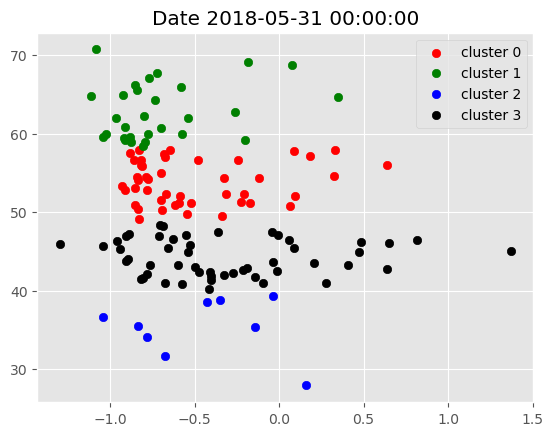

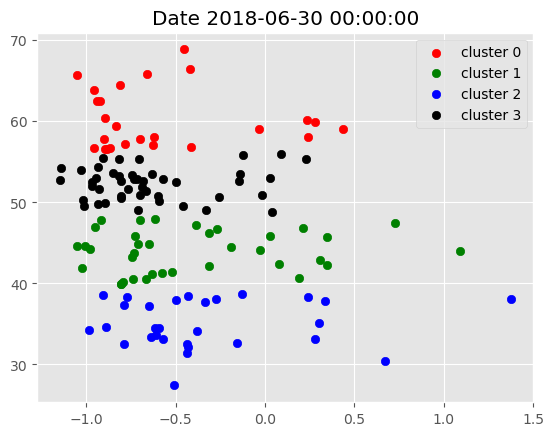

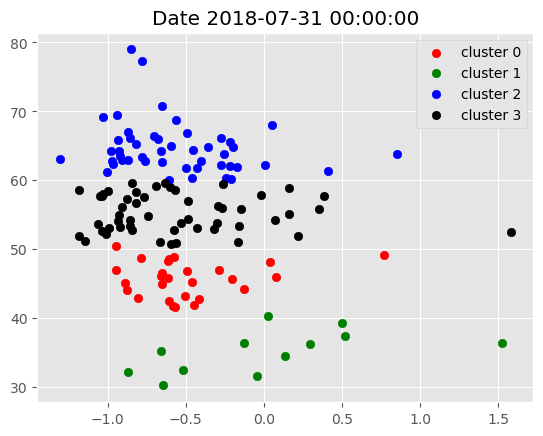

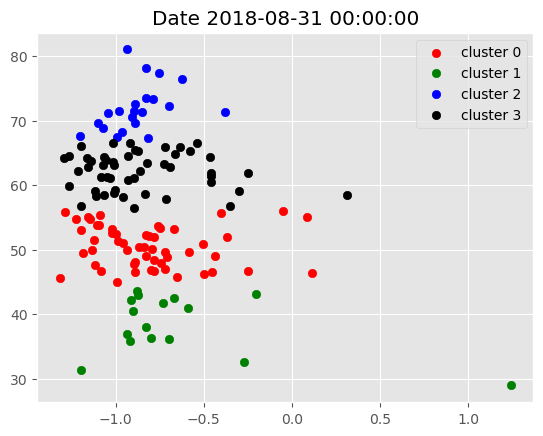

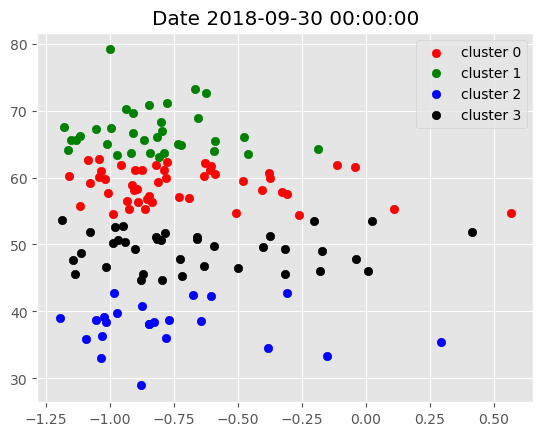

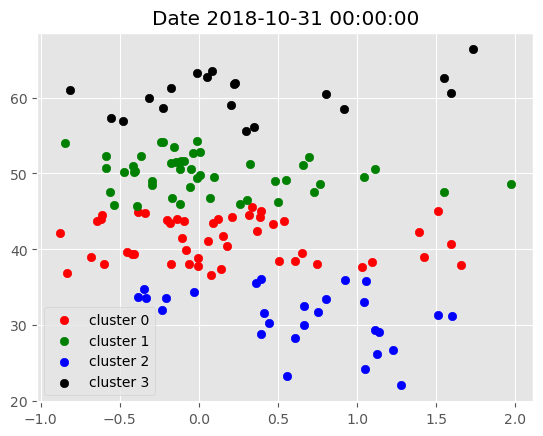

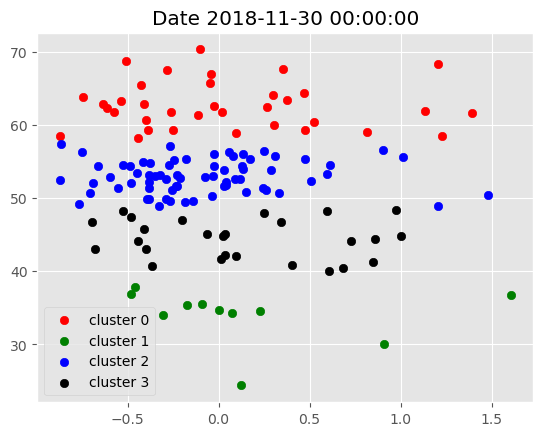

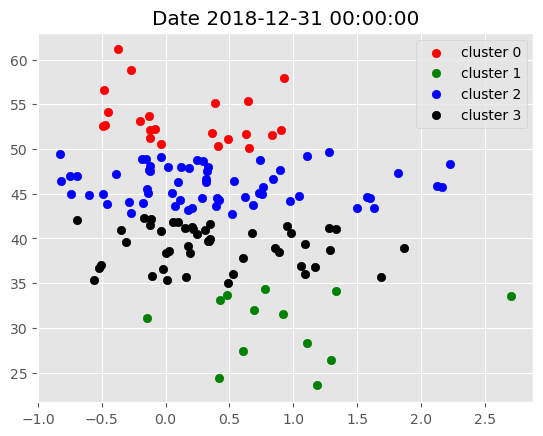

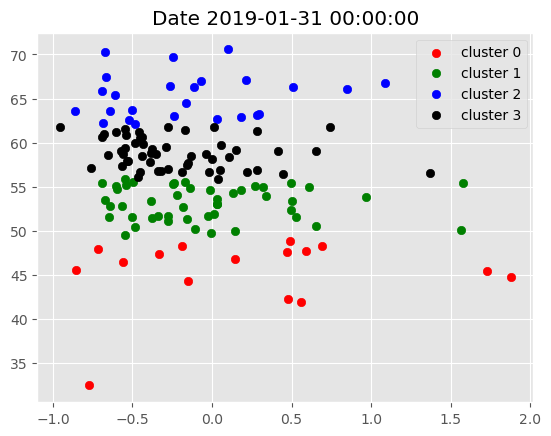

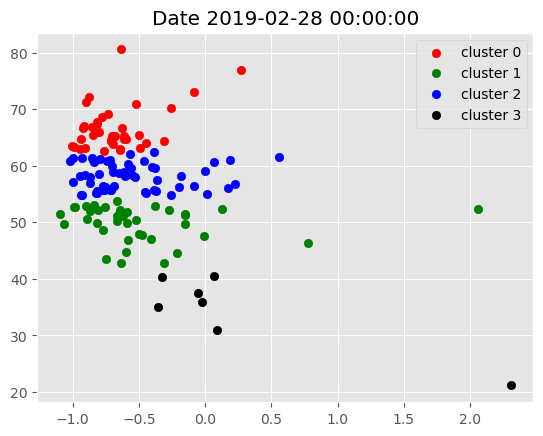

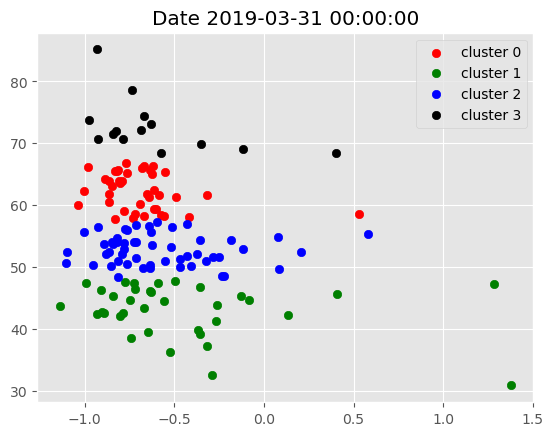

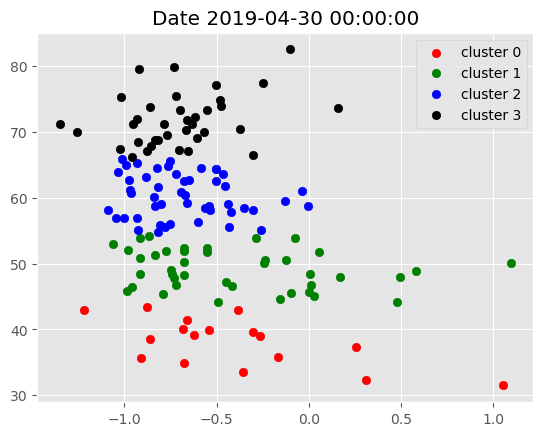

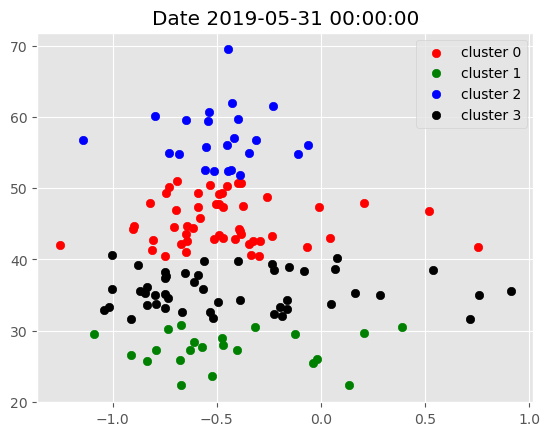

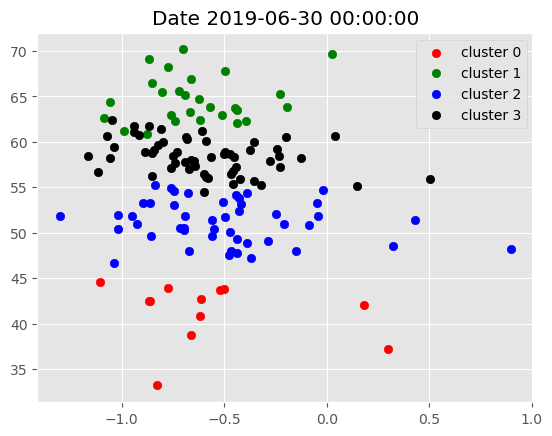

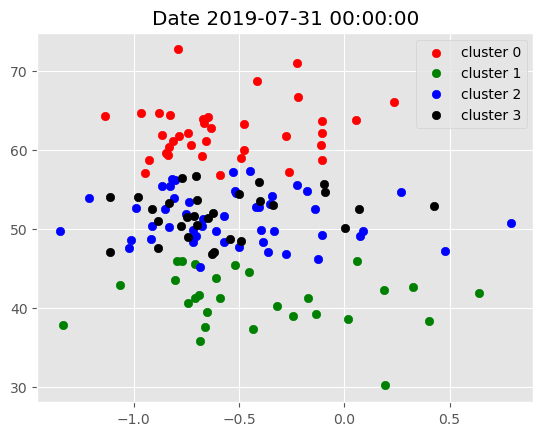

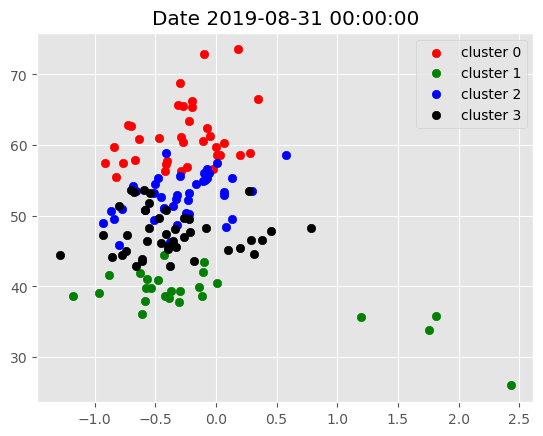

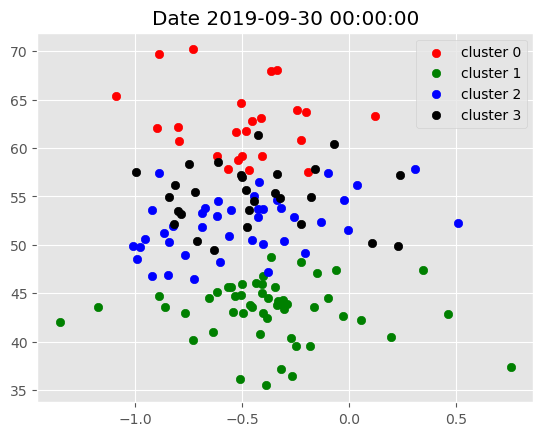

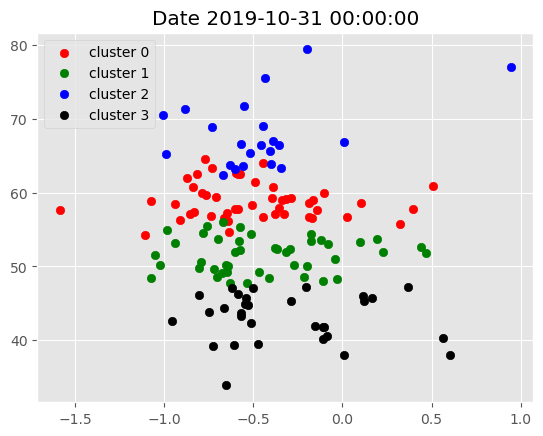

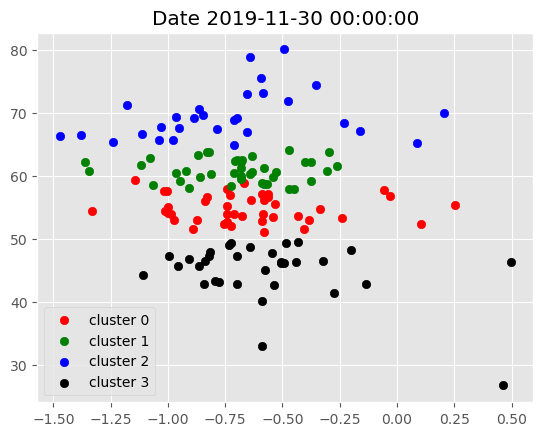

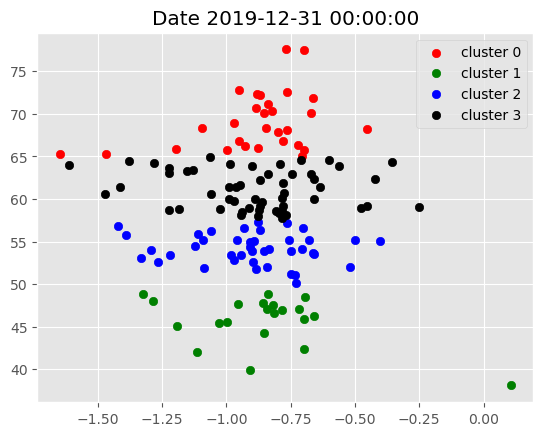

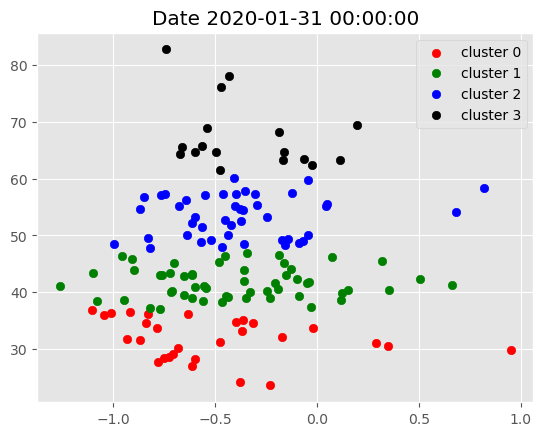

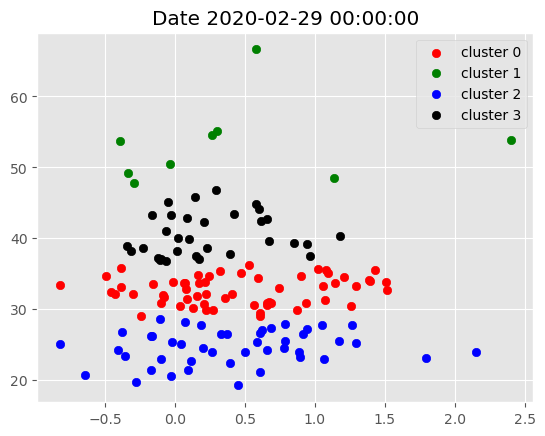

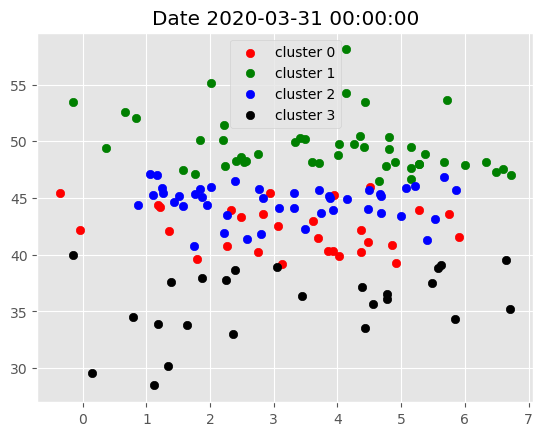

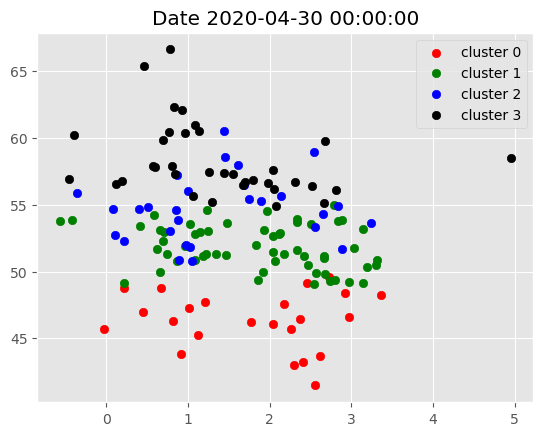

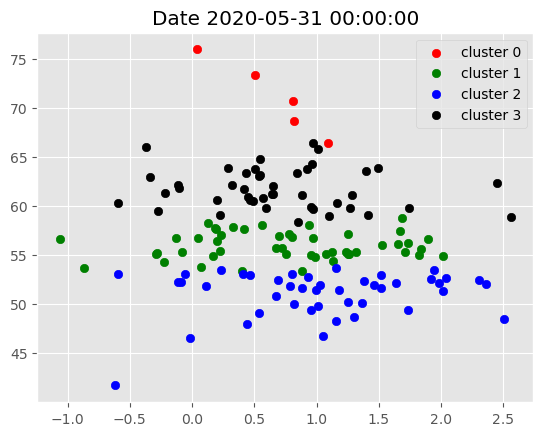

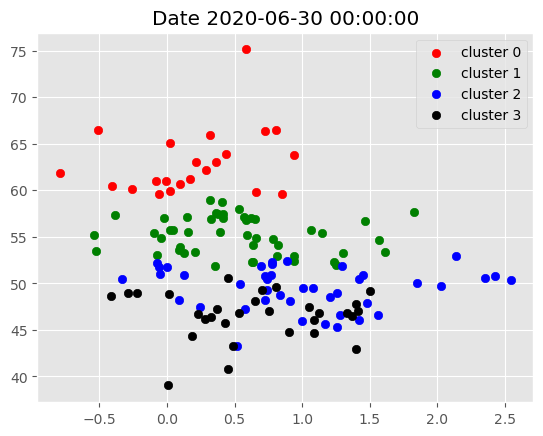

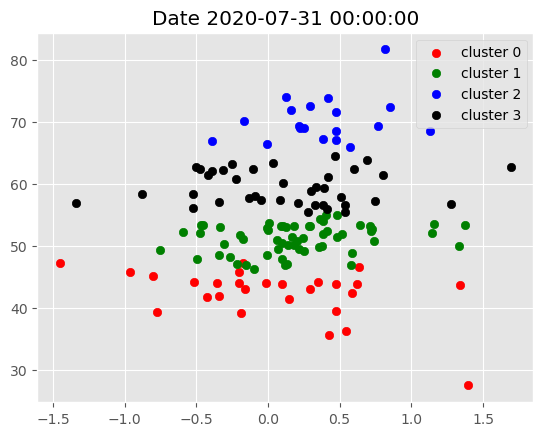

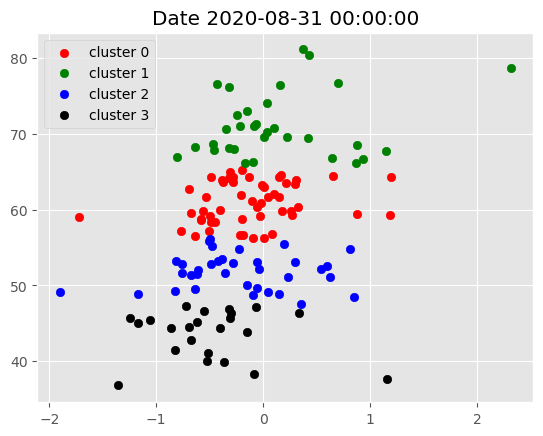

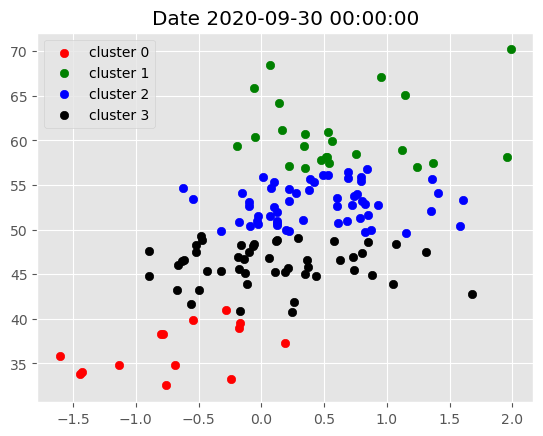

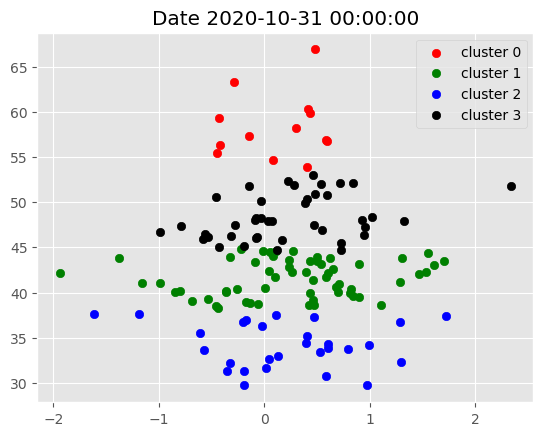

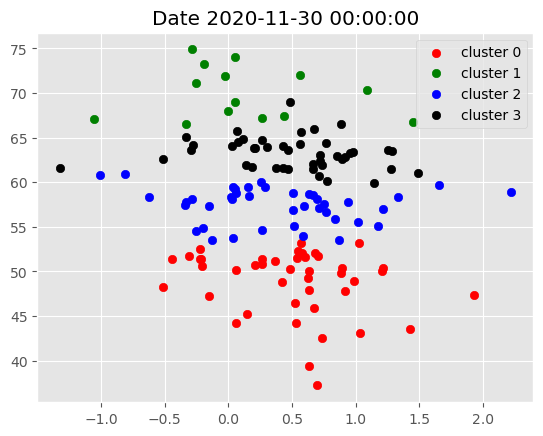

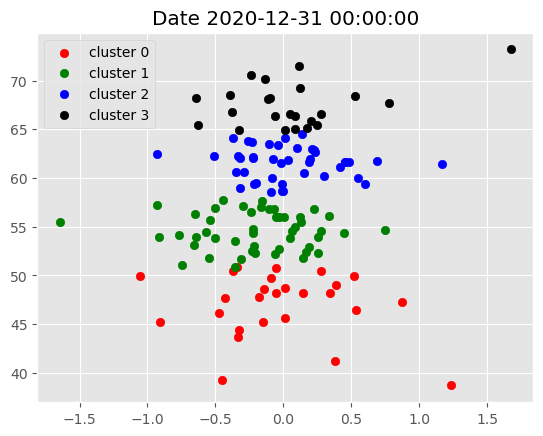

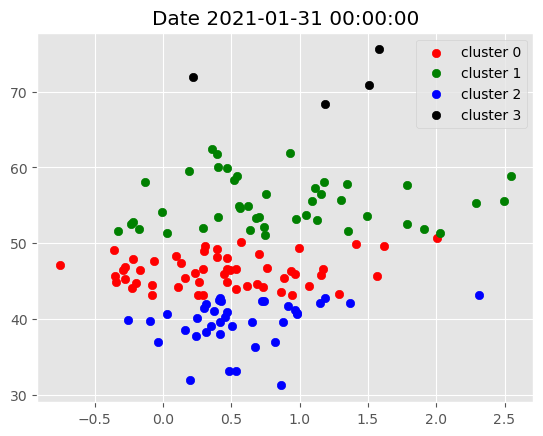

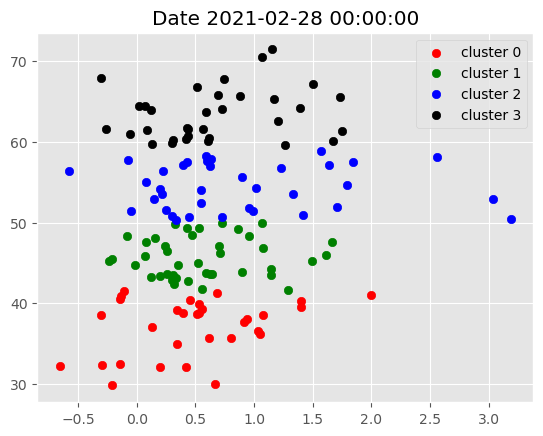

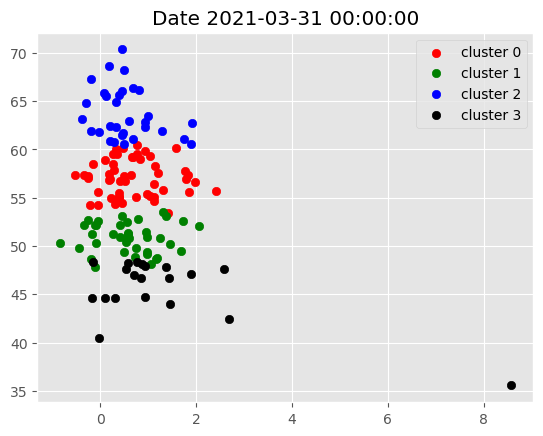

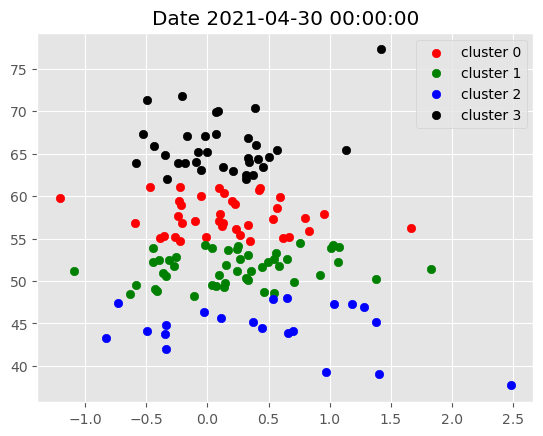

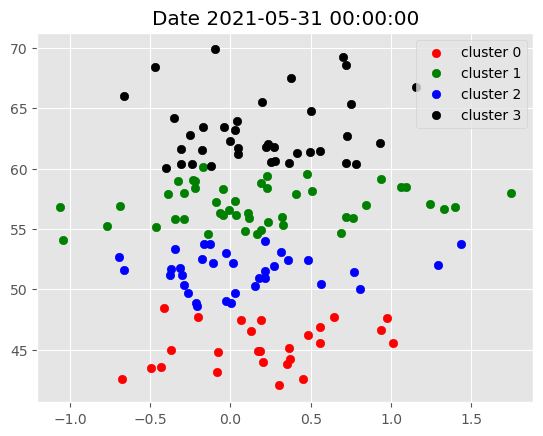

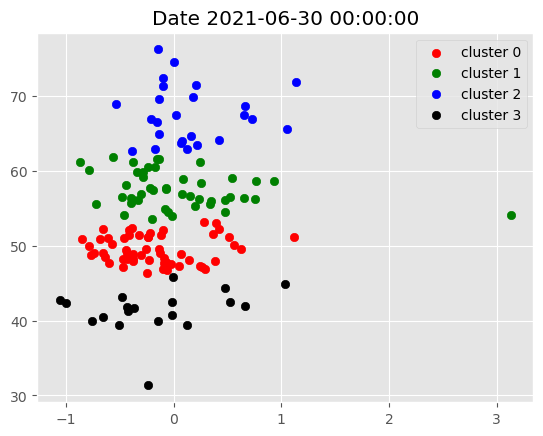

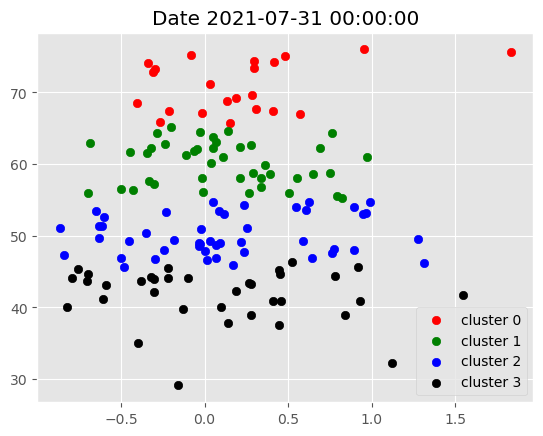

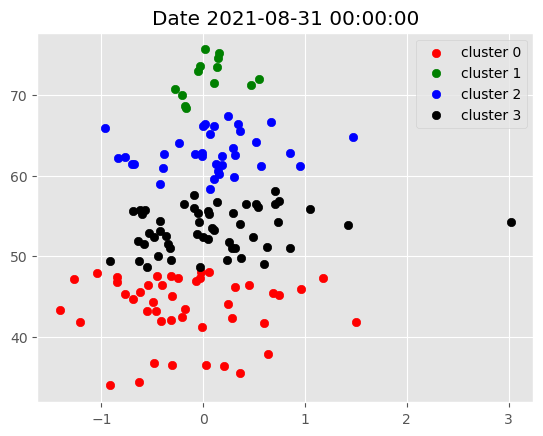

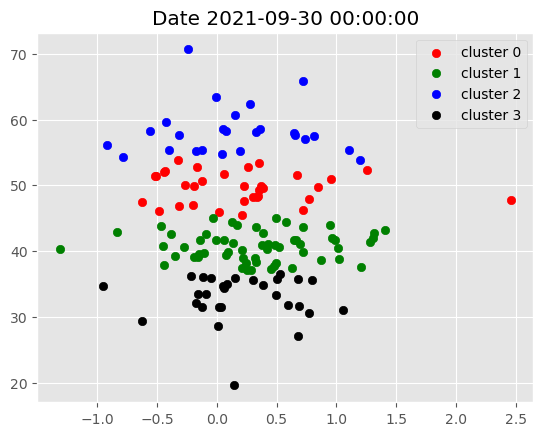

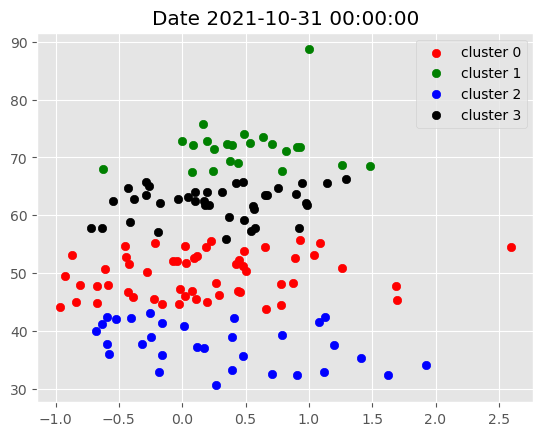

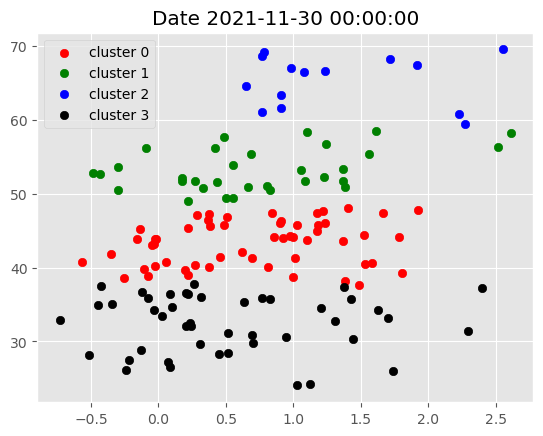

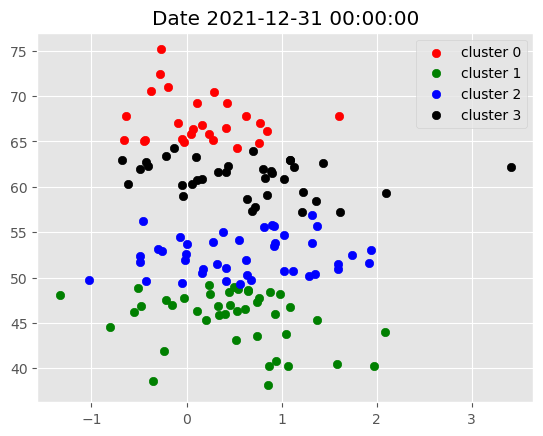

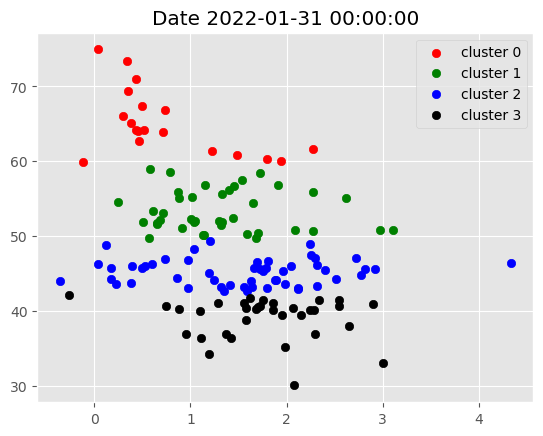

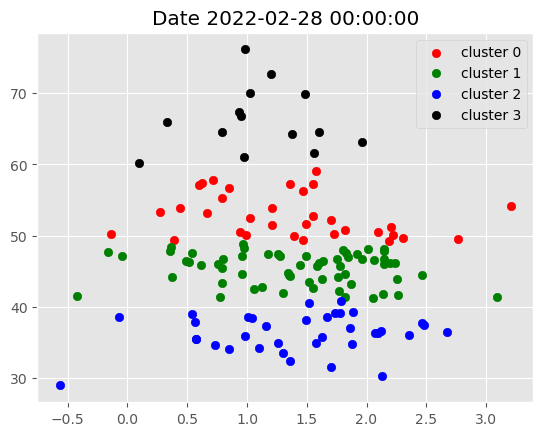

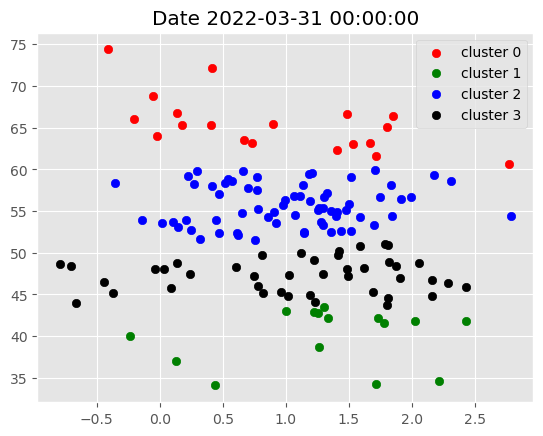

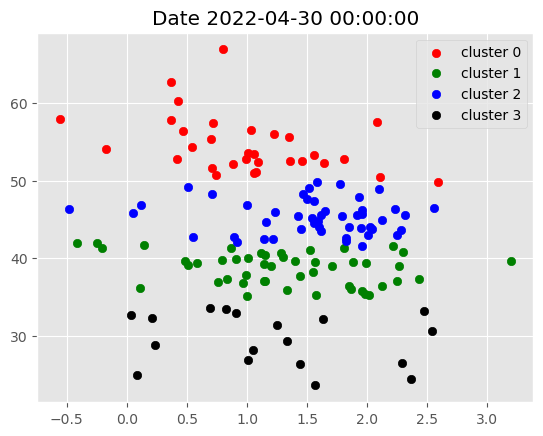

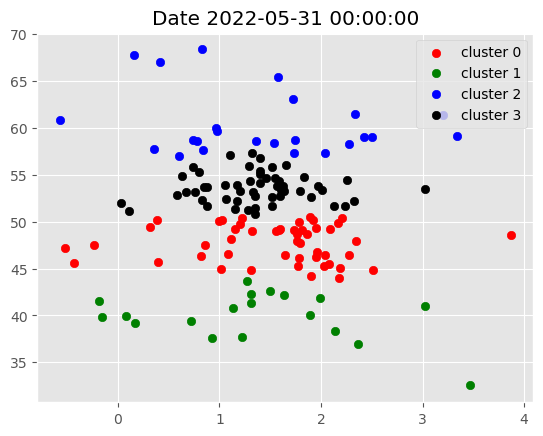

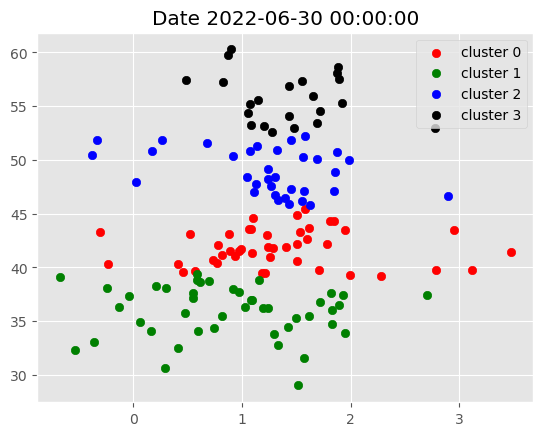

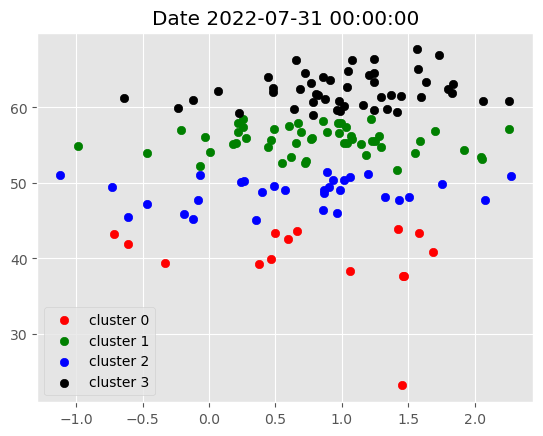

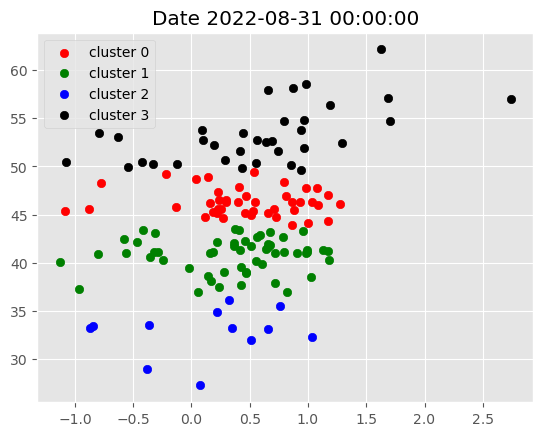

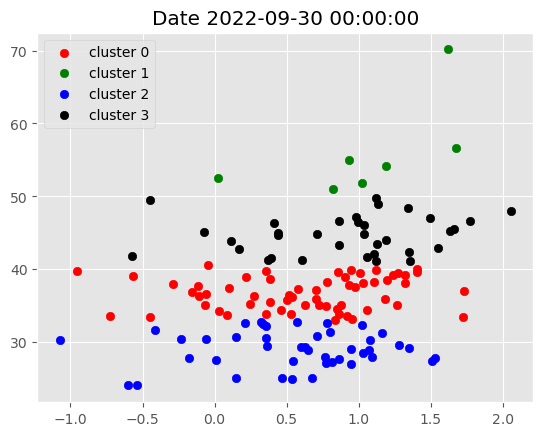

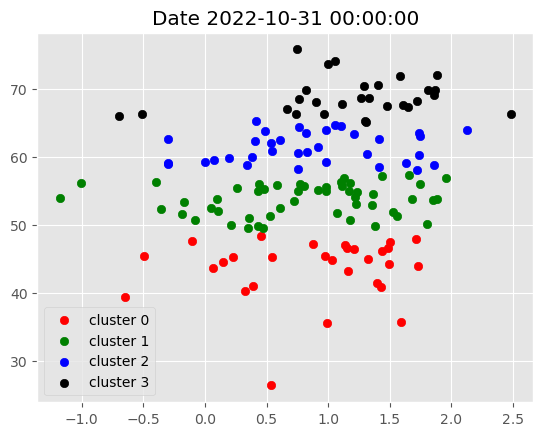

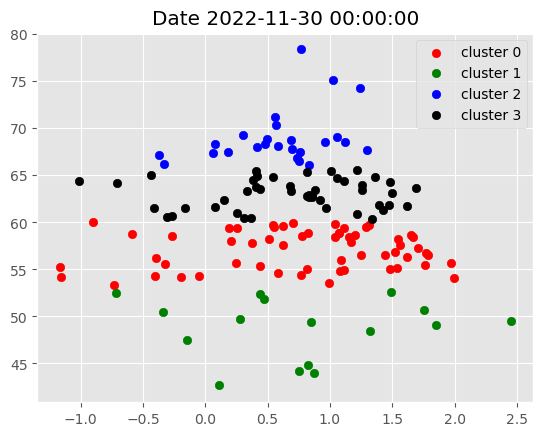

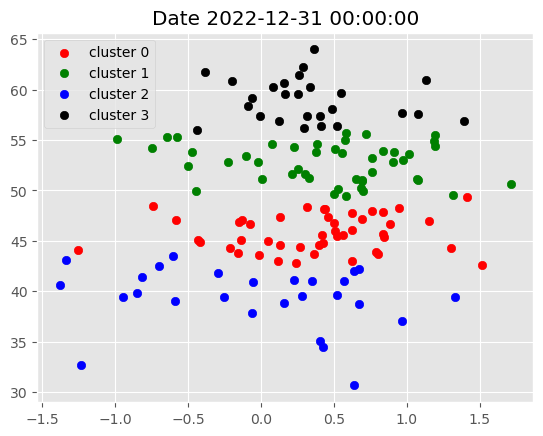

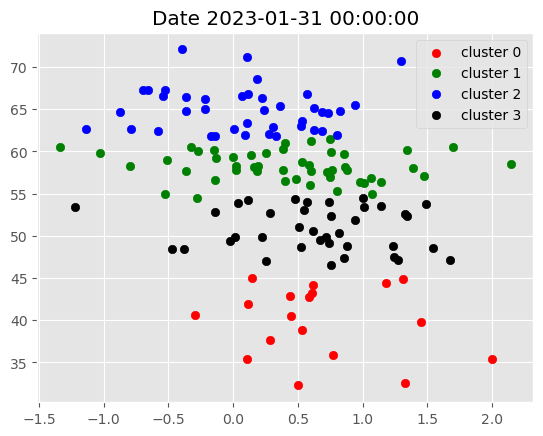

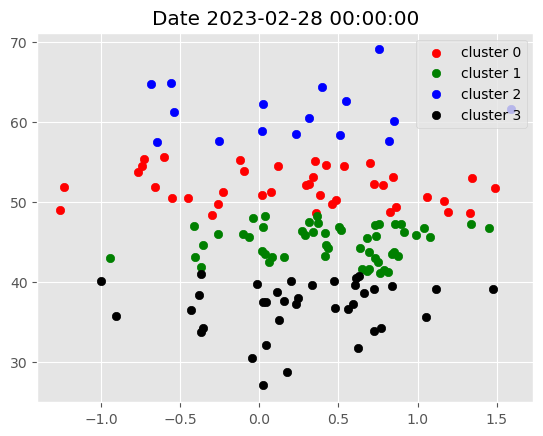

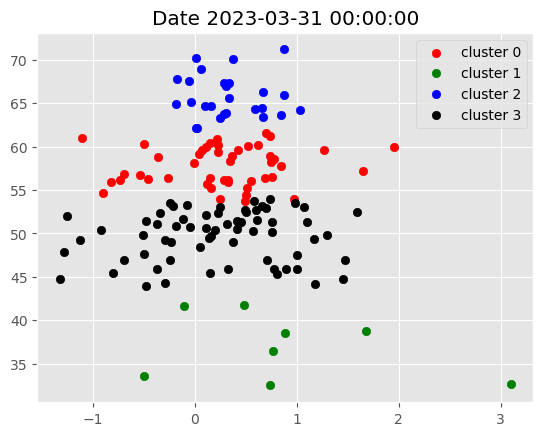

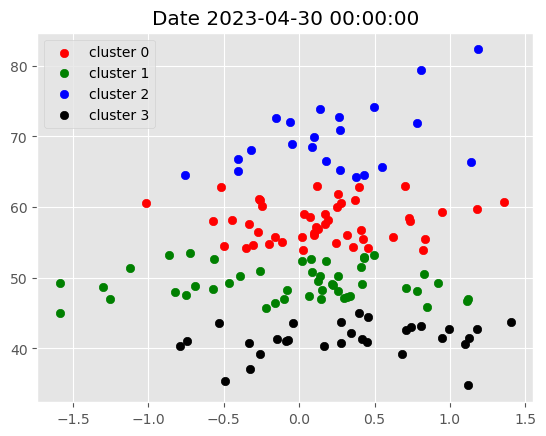

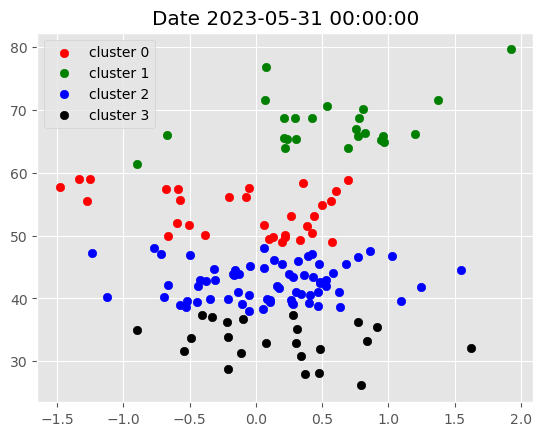

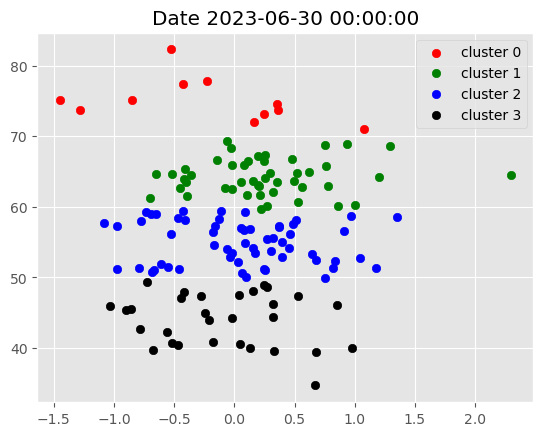

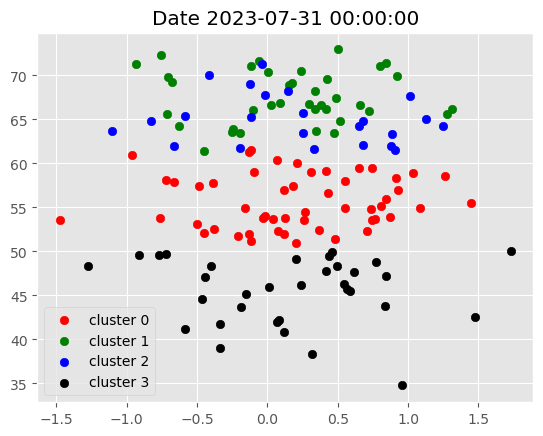

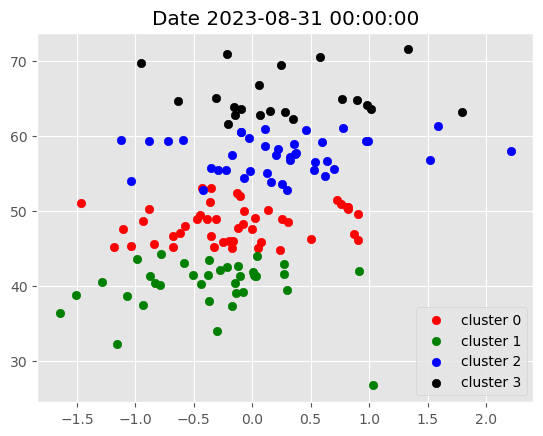

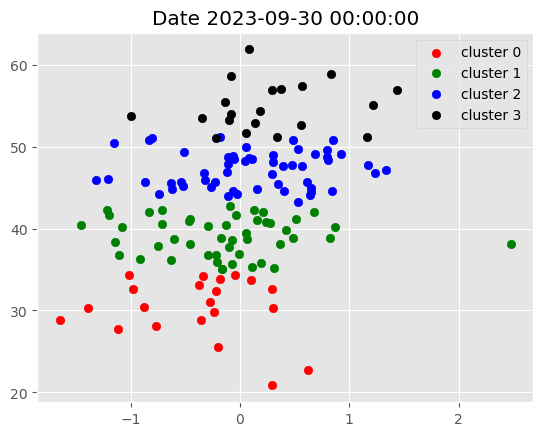

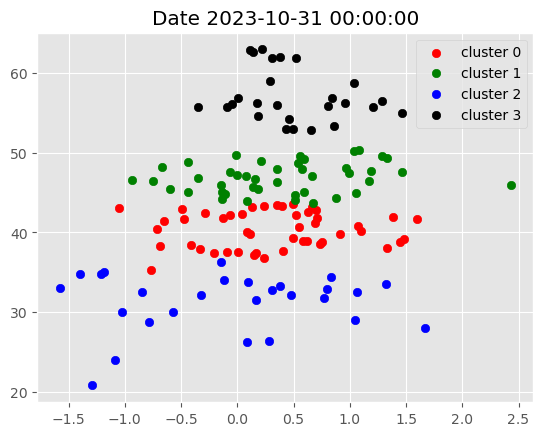

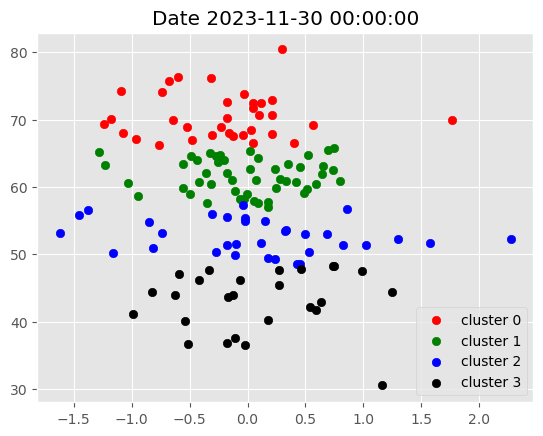

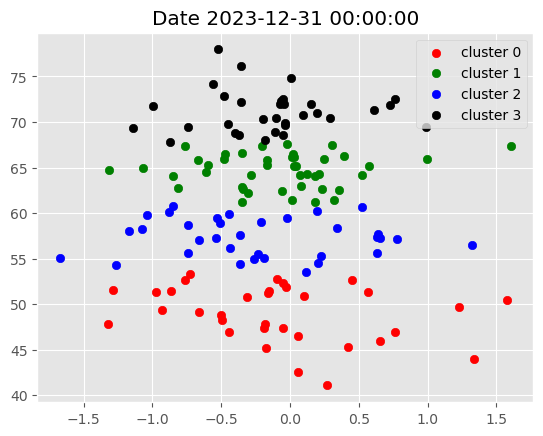

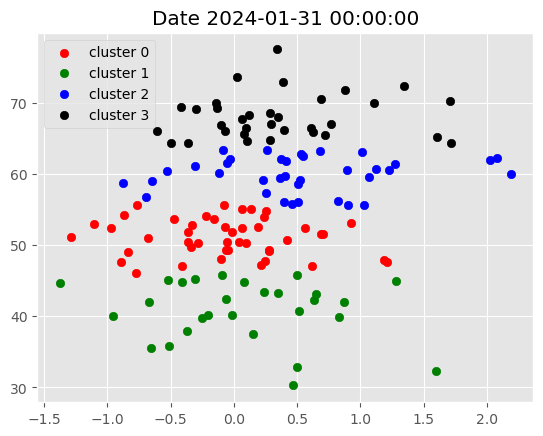

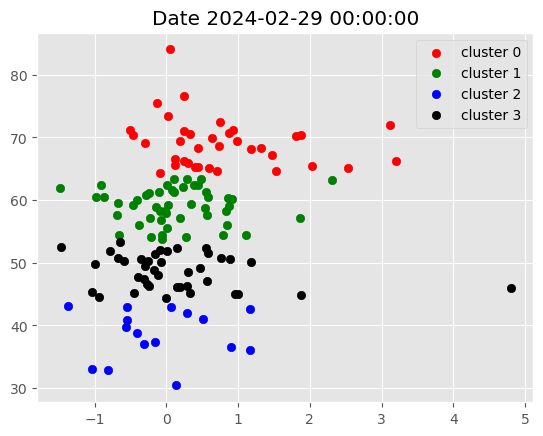

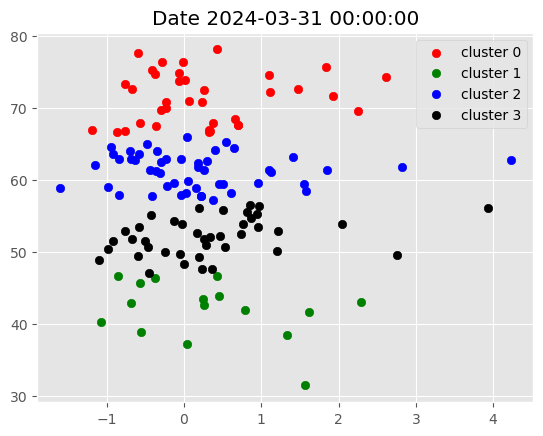

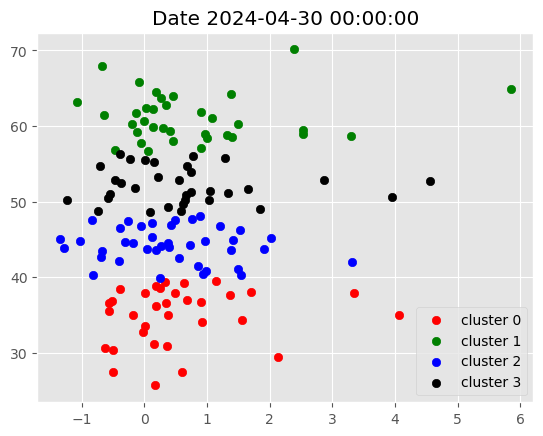

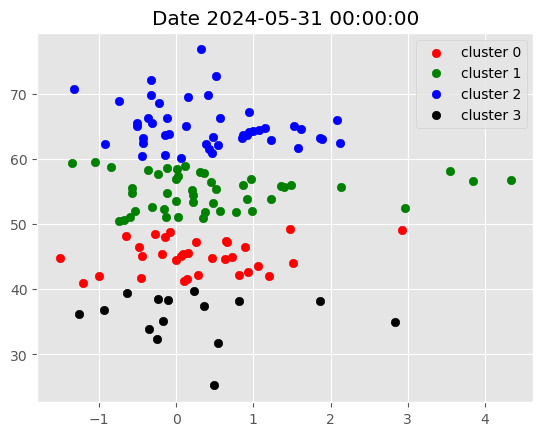

In [16]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

# reapplying the clustering 

In [17]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 17))

initial_centroids[:, 5] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]])

In [18]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-05-31 AAL     1.371281  3.801628  3.728982  3.765305          0.000660   
           AAPL   -1.026026  3.844051  3.784342  3.814196         -0.001003   
           ABBV    0.483896  4.422443  4.323378  4.372910         -0.032834   
           ABT    -0.773944  4.066918  3.981285  4.024102         -0.004457   
           ACN    -0.853128  4.982193  4.942734  4.962464         -0.002942   
...                     ...       ...       ...       ...               ...   
2024-05-31 VRTX    1.152809  6.063452  5.949887  6.006669          0.000154   
           VZ     -0.575182  3.732135  3.677752  3.704943          0.000020   
           WFC    -0.227148  4.149019  4.071832  4.110425          0.000113   
           WMT     0.565754  4.123502  4.089234  4.106368          0.000125   
           XOM     0.451999  4.803086  4.744902  4.773994          0.000036   

                         rsi  return_1m  return_2m  return_3m  return_6m  \
date       ticker                                                          
2018-05-31 AAL     45.114574   0.016581  -0.083533  -0.069961  -0.023688   
           AAPL    59.945424   0.135124   0.057390   0.017418   0.015402   
           ABBV    46.193266   0.024754   0.027693  -0.047916   0.006367   
           ABT     54.184883   0.058489   0.015781   0.008199   0.016325   
           ACN     53.108585   0.030026   0.011704  -0.008131   0.009999   
...                      ...        ...        ...        ...        ...   
2024-05-31 VRTX    64.790517   0.091087   0.012576   0.006181   0.031987   
           VZ      54.810677   0.025323  -0.009751   0.009289   0.014709   
           WFC     68.511672   0.049322   0.036313   0.038415   0.058405   
           WMT     51.977150   0.012084  -0.000855   0.009363   0.025882   
           XOM     56.409657   0.003008   0.010210   0.043101   0.025832   

                   return_9m  return_12m    Mkt-RF       SMB       HML  \
date       ticker                                                        
2018-05-31 AAL     -0.002302   -0.008097  1.294504  1.810254  0.120079   
           AAPL     0.015909    0.018245  1.241497 -0.307947 -0.653795   
           ABBV     0.033601    0.037166  0.602155  0.086033 -0.045139   
           ABT      0.022849    0.026878  0.869802 -0.183765 -0.434174   
           ACN      0.021704    0.020418  1.328230 -0.414686 -0.274656   
...                      ...         ...       ...       ...       ...   
2024-05-31 VRTX     0.023303    0.023700  0.856440  0.152323 -1.114997   
           VZ       0.022492    0.016765  0.542184 -0.132882 -0.089848   
           WFC      0.048512    0.039999  1.064106  0.216862  1.233885   
           WMT      0.012278    0.018094  0.618270 -0.359420 -0.213789   
           XOM      0.009275    0.014754  1.127936  0.374182  0.394283   

                        RMW       CMA  cluster  
date       ticker                               
2018-05-31 AAL     0.695025  0.702824        1  
           AAPL    0.875492  0.542572        2  
           ABBV   -0.378999  0.210806        1  
           ABT     0.274010  1.110124        2  
           ACN    -0.329218  0.185110        2  
...                     ...       ...      ...  
2024-05-31 VRTX   -0.213695  1.044357        3  
           VZ      0.680381  0.583334        2  
           WFC    -0.549230 -0.576795        3  
           WMT     0.691141  0.662598        2  
           XOM    -0.044434  0.674810        2  

[10456 rows x 18 columns]

# selecting assets based on the cluster and forming an efficient frontier max sharpe ratio optimization

In [19]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'META',
  'NEE',
  'NFLX',
  'OXY',
  'PANW',
  'TJX',
  'TXN',
  'VLO'],
 '2018-07-01': ['ACN',
  'AMT',
  'BSX',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'KR',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'TJX',
  'VZ'],
 '2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BDX',
  'BMY',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'LLY',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MPC',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WMT'],
 '2018-09-01': ['AAPL',
  'ADP',
  'AMD',
  'AMZN',
  'BDX',
  'COST',
  'CSCO',
  'CVS',
  'DAL',
  'ISRG',
  'LLY',
  'LOW',
  'MDT',
  'ORLY',
  'QCOM',
  'REGN',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'V'],
 '2018-10-01': ['ABT'

# Optimizing the weights of a portfolio

In [20]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


In [21]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  163 of 163 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV        ABNB         ABT   
Date                                                                    
2017-05-31  46.985199   35.748726   48.592529         NaN   40.407574   
2017-06-01  47.606365   35.847019   49.100395         NaN   40.796959   
2017-06-02  48.062527   36.378231   49.497856         NaN   41.150944   
2017-06-05  48.276058   36.022522   49.689213         NaN   41.257141   
2017-06-06  48.276058   36.144226   49.954201         NaN   41.027050   
...               ...         ...         ...         ...         ...   
2024-05-20  14.520000  191.039993  164.559998  146.369995  103.209999   
2024-05-21  14.030000  192.350006  162.929993  144.100006  102.959999   
2024-05-22  14.100000  190.899994  159.610001  142.710007  104.820000   
2024-05-23  13.820000  186.880005  158.259995  141.039993  104.230003   
2024-05-24  13.840000  189.979996  157.059998  144.470001  103.949997   

Price                                                                   ...  \
Ticker             ACN        ADBE         ADI         ADP        ADSK  ...   
Date                                                                    ...   
2017-05-31  112.053131  141.860001   74.848579   88.319992  111.769997  ...   
2017-06-01  112.791328  141.380005   71.750275   89.165482  113.029999  ...   
2017-06-02  113.196449  143.479996   70.615662   87.120781  112.910004  ...   
2017-06-05  113.952629  143.589996   68.730484   87.224289  110.879997  ...   
2017-06-06  113.727577  143.029999   69.908730   87.310562  111.449997  ...   
...                ...         ...         ...         ...         ...  ...   
2024-05-20  305.700012  484.690002  217.479996  251.779999  221.399994  ...   
2024-05-21  303.640015  481.850006  216.639999  252.139999  220.279999  ...   
2024-05-22  307.109985  483.929993  240.160004  254.020004  219.960007  ...   
2024-05-23  305.929993  483.309998  234.559998  251.490005  215.160004  ...   
2024-05-24  300.989990  475.429993  232.509995  248.899994  214.889999  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2017-05-31   9866000  4655900  2813600  22811100   4355600  5531700  30519700   
2017-06-01   8911900  3541400  3356300  14219400   3692500  3520300  21001800   
2017-06-02   8570200  2788900  2837100  18552800   3940900  3191100  19477300   
2017-06-05  14510500  3897100  2030000   8538200   2824000  4286100  13663800   
2017-06-06   7030300  2579800  1250600  11610500   6663800  3626200  14887500   
...              ...      ...      ...       ...       ...      ...       ...   
2024-05-20   5460900  3089100   742200   8665000   6923900  5603200  15029000   
2024-05-21   6578200  2206800  1106700  18327000  25075400  4782000  18422100   
2024-05-22   4202500  2510000  1084600  12374100  12099500  3446900  10340500   
2024-05-23   6115900  2251400  1554700  14105000  16012300  5393000  13056100   
2024-05-24   4339700  1794500  1050600  10418800  10541200  2743100   9912500   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-05-31  24605100  1697100  13572300  
2017-06-01  24459300  4059300   9884100  
2017-06-02  23989500  2293600  21687300  
2017-06-05  30437100  1423700  11527100  
2017-06-06  34577700  1892400  12208600  
...              ...      ...       ...  
2024-05-20  15001400  1182200  11551300  
2024-05-21  17131700  1403800  14495000  
2024-05-22  14879400  1319000  17879300  
2024-05-23  16222900  1465100  15979800  
2024-05-24  11793800  1035400  12211400  

[1759 rows x 978 columns]

In [22]:
#Creates a return for each stock, select stock each month and loop for next month, 
#if the maximum sharpe ratio optimization fails for a given month, weights are applied equally

returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"


,Strategy Return
date,
2018-06-01,0.009637
2018-06-04,0.005540
2018-06-05,0.000239
2018-06-06,0.001665
2018-06-07,-0.008104
...,...
2024-05-20,0.004103
2024-05-21,0.007218
2024-05-22,-0.007525


In [23]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end='2023-09-30')

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-06-01,0.009637,0.009770
2018-06-04,0.005540,0.004740
2018-06-05,0.000239,0.000727
2018-06-06,0.001665,0.008326
2018-06-07,-0.008104,-0.000108
...,...,...
2023-09-25,0.003695,0.004196
2023-09-26,-0.011903,-0.014800
2023-09-27,0.004926,0.000399
2023-09-28,0.008090,0.005781


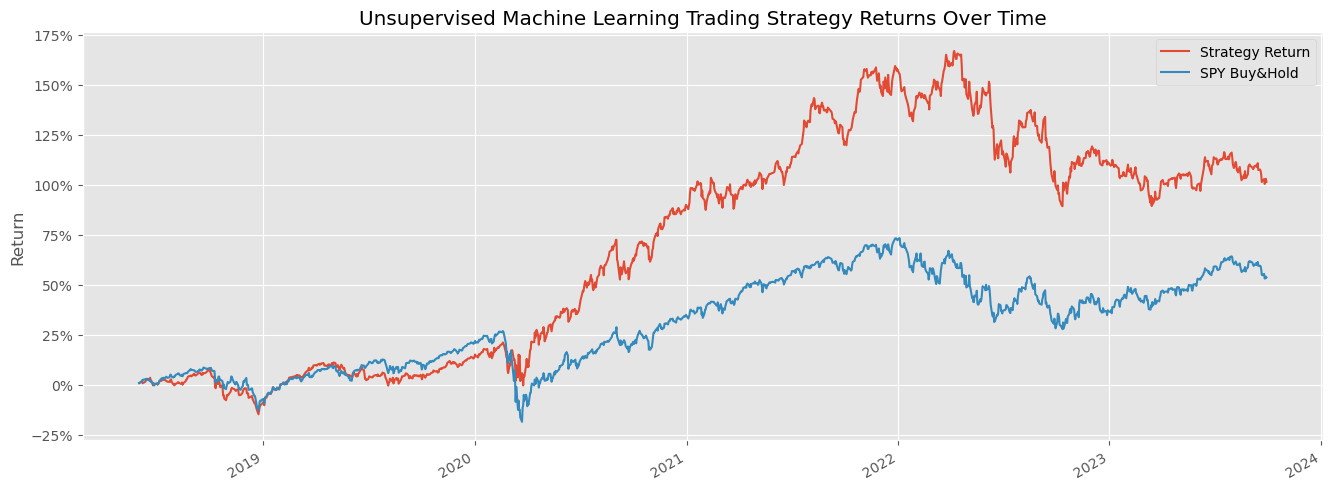

In [24]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-05-15'].plot(figsize=(16,6))

plt.title('Unsupervised Machine Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
